In [1]:
#DTW calculation

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
%matplotlib inline

In [2]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [3]:
def plot_transportation_mod(transportation_mode, df):
    data = df[df['activity'] == transportation_mode][['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']][:8000]
    
    axis = data.plot(subplots = True, figsize =(20, 20), title = transportation_mode)
    
    for ax in axis:
        ax.legend(loc = 'lower left', bbox_to_anchor=(1.0,0.5))


In [4]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1

In [5]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [6]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
    
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        if( len(df) > len(complexs)):
            complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
            
        df[output_features[i]] = complexs
    return df

In [7]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gz = df['GZ'].values[i: i + N_TIME_STEPS]
        gy = df['GY'].values[i: i + N_TIME_STEPS]
    
        label = "ST"
        segments.append([gz,gy])
        labels.append(label)
    return segments, labels

In [8]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(10,2))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [9]:
def data_preprocessing(df):
    df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 5
    df = GaussianFilter(df, 5)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    return df

In [10]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [11]:
def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path

In [12]:
def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [13]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [14]:
def loss_for_segments(segments, comp, dist_fun):
    loss =[]
    length = len(segments)
    for i in range(length):
        x = segments[i][0]
#         dist, cost, acc, path = dtw(x, y, dist_fun)
        dist = DTWDistance(x, comp, 50)
        print(i , '=>', dist)
        loss.append(dist)
        
    return loss
    

In [25]:
#data for car

acc_file = 'data/car/2018-08-17_16-50-00/AccelerometerLinear.csv'
gyro_file= 'data/car/2018-08-17_16-50-00/Gyroscope.csv'

df_car1 = read_csv_file(acc_file, gyro_file, 'car')
n = len(df_car1)
df_car = df_car1[4100 : 5100]
df_car.reset_index(drop = True, inplace = True)

df_car1 = df_car1[3000 : n-5000]
df_car1.reset_index(drop = True, inplace = True)

df_car = data_preprocessing(df_car)
print("shape -", df_car.shape)



shape - (1000, 16)


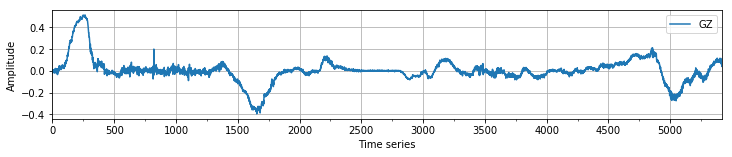

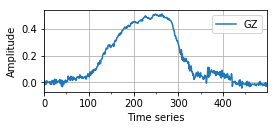

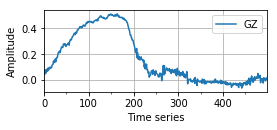

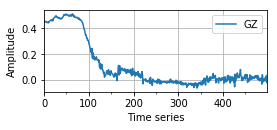

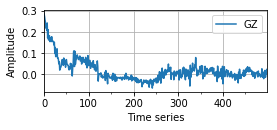

In [37]:
n = len(df_car1)
fig, ax = plt.subplots()
df_car1[['GZ']].plot(figsize = (12,2),ax=ax)
plt.xlabel('Time series')
plt.ylabel('Amplitude')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)
plt.show()

df_car = df_car1[ : 500]
df_car.reset_index(drop = True, inplace = True)

n = len(df_car)
fig, ax = plt.subplots()
df_car[['GZ']].plot(figsize = (4,1.5),ax=ax)
plt.xlabel('Time series')
plt.ylabel('Amplitude')
major_ticks = np.arange(0, n, 100)
minor_ticks = np.arange(0, n, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)
plt.show()

df_car = df_car1[ 100 : 600]
df_car.reset_index(drop = True, inplace = True)

n = len(df_car)
fig, ax = plt.subplots()
df_car[['GZ']].plot(figsize = (4,1.5),ax=ax)
plt.xlabel('Time series')
plt.ylabel('Amplitude')
major_ticks = np.arange(0, n, 100)
minor_ticks = np.arange(0, n, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)
plt.show()

df_car = df_car1[ 200 : 700]
df_car.reset_index(drop = True, inplace = True)

n = len(df_car)
fig, ax = plt.subplots()
df_car[['GZ']].plot(figsize = (4,1.5),ax=ax)
plt.xlabel('Time series')
plt.ylabel('Amplitude')
major_ticks = np.arange(0, n, 100)
minor_ticks = np.arange(0, n, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)
plt.show()

df_car = df_car1[ 300 : 800]
df_car.reset_index(drop = True, inplace = True)

n = len(df_car)
fig, ax = plt.subplots()
df_car[['GZ']].plot(figsize = (4,1.5),ax=ax)
plt.xlabel('Time series')
plt.ylabel('Amplitude')
major_ticks = np.arange(0, n, 100)
minor_ticks = np.arange(0, n, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)
plt.show()


In [57]:
# #data for car
# acc_file = 'data/car/2018-08-17_16-50-00/AccelerometerLinear.csv'
# gyro_file= 'data/car/2018-08-17_16-50-00/Gyroscope.csv'

# df_car1 = read_csv_file(acc_file, gyro_file, 'car')
# n = len(df_car1)
# df_car1 = df_car1[500 : n-1000]
# df_car1.reset_index(drop = True, inplace = True)
# df_car1 = data_preprocessing(df_car1)
# print("shape -", df_car1.shape)



In [58]:
# print("shape -", df_car.shape)
# print("shape -", df_car1.shape)

# df = pd.concat([df_car, df_car1])
# df.reset_index(drop = True, inplace = True)
# n = len(df)
# print("shape -", df.shape)
# df.head()

In [59]:

# fig, ax = plt.subplots()
# df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
# plt.xlabel('Time series')
# plt.ylabel('Amplitude ($rad/s$)')
# major_ticks = np.arange(0, n, 500)
# minor_ticks = np.arange(0, n, 250)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)

# plt.grid(True)


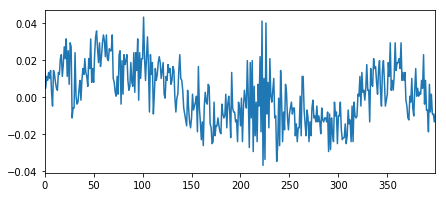

In [60]:
car_segments, car_labels = segmentation(df_car1, 400)
np.array(car_segments).shape
x = car_segments[10][0]
xx = pd.Series(x)
xx.plot(figsize = (7,3))

In [78]:

# car_labels[5:6] = ["LT"] * (6-5)
# car_labels[35:50] = ["RT"] * (50-35)
# car_labels[152:162] = ["LT"] * (162-152)
# car_labels[180:193] = ["RT"] * (193-180)
# car_labels[240:252] = ["LT"] * (252-240)
# car_labels[250:260] = ["RT"] * (260-250)
# car_labels[263:275] = ["RT"] * (275-263)
# car_labels[290:300] = ["RT"] * (300-290)
# car_labels[313:325] = ["LT"] * (325-313)


# fig, ax = plt.subplots()
# df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
# plt.xlabel('Time series')
# plt.ylabel('Amplitude ($rad/s$)')
# major_ticks = np.arange(0, n, 500)
# minor_ticks = np.arange(0, n, 250)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)

# plt.grid(True)

# loss_series = pd.Series(diff_wrt_LT)
# car_colors = pltcolor(car_labels)

# from matplotlib.patches import Patch
# from matplotlib.lines import Line2D

# legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
#                    Line2D([0], [0], color='r', lw=2, label='Right Turn'),
#                    Line2D([0], [0], color='g', lw=2, label='Left Turn')]

# y = loss_series
# x = np.arange(len(y))
# plot_multicolored_lines(x,y,car_colors)
# plt.xlabel('Segment numbers')
# plt.ylabel('Difference')
# plt.title("DTW with respect to Left Turn segment")
# plt.legend(handles=legend_elements, loc='upper right')

# plt.grid(True)
# plt.show()

In [62]:
dist_fun = manhattan_distances
ref  = [0.0]*400
len(ref)
diff_wrt_LT = loss_for_segments(car_segments, ref ,dist_fun)
loss_series = pd.Series(diff_wrt_LT)
loss_series.to_csv('fiff_wrt_LT_car')

0 => 5.01160895925
1 => 4.98496842827
2 => 4.9331114626
3 => 4.11688402338
4 => 2.66610182974
5 => 0.390523610455
6 => 0.376899817641
7 => 0.355152326583
8 => 0.328178858396
9 => 0.322793754266
10 => 0.31288574379
11 => 0.349235786474
12 => 0.340047423205
13 => 0.350556935301
14 => 0.413904552371
15 => 0.463233397961
16 => 0.469371539002
17 => 0.464855187694
18 => 0.470254383713
19 => 0.454148585928
20 => 0.476824875457
21 => 0.491077606294
22 => 0.437540232669
23 => 0.419573879374
24 => 0.432862420924
25 => 0.514980461154
26 => 0.581118924362
27 => 0.594669997608
28 => 0.608331295309
29 => 0.611131464271
30 => 0.612931644098
31 => 0.578869629
32 => 0.566595866932
33 => 0.519012333809
34 => 0.443092764534
35 => 0.425217276103
36 => 0.4064923142
37 => 0.422590252545
38 => 0.496479273965
39 => 0.497131203203
40 => 0.509421744062
41 => 0.497413522891
42 => 0.496221210665
43 => 0.492332377738
44 => 0.465563537252
45 => 0.4265010743
46 => 0.338716880467
47 => 0.355111612501
48 => 0.43189107

In [65]:
# dist_fun = manhattan_distances
# y = car_segments[65][0]
# diff_wrt_ST = loss_for_segments(car_segments, y ,dist_fun)
# loss_series = pd.Series(diff_wrt_LT)
# loss_series.to_csv('fiff_wrt_ST_car')

In [63]:
# loss_series = pd.Series(diff_wrt_ST)
# from matplotlib.patches import Patch
# from matplotlib.lines import Line2D

# fig, ax = plt.subplots()
# df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
# plt.xlabel('Time series')
# plt.ylabel('Amplitude ($rad/s$)')
# major_ticks = np.arange(0, n, 500)
# minor_ticks = np.arange(0, n, 250)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)

# plt.grid(True)

# legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
#                    Line2D([0], [0], color='r', lw=2, label='Right Turn'),
#                    Line2D([0], [0], color='g', lw=2, label='Left Turn')]

# y = loss_series
# x = np.arange(len(y))
# plot_multicolored_lines(x,y,car_colors)
# plt.xlabel('Segment numbers')
# plt.ylabel('Difference')
# plt.title("DTW with respect to straight-line segment")
# plt.legend(handles=legend_elements, loc='upper right')

# plt.grid(True)
# plt.show()

In [64]:
# dist_fun = manhattan_distances
# y = car_segments[10][0]
# diff_wrt_RT = loss_for_segments(car_segments, y ,dist_fun)
# loss_series_RT = pd.Series(diff_wrt_LR)
# loss_series_RT.to_csv('Diff_wrt_RT_car')

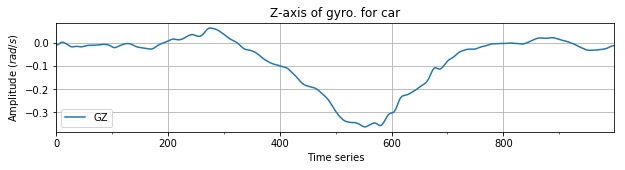

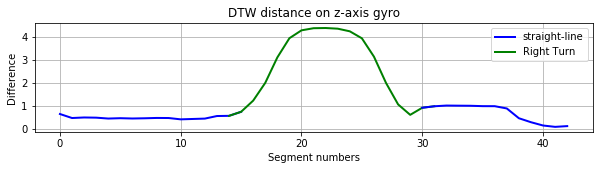

In [122]:
fig, ax = plt.subplots()
df_car[['GZ']].plot(figsize = (10,2),ax=ax, title = "Z-axis of gyro. for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 200)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

car_labels[1:15] = ["ST"] * (15-1)
car_labels[15:30] = ["RT"] * (30-15)


legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='g', lw=2, label='Right Turn')]

car_colors = pltcolor(car_labels)
y = loss_series[67:110]
x = np.arange(len(y))

plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW distance on z-axis gyro")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

In [26]:
dist_fun = manhattan_distances
y = car_segments[65][0]
diff_wrt_ST = loss_for_segments(car_segments, y ,dist_fun)
loss_series = pd.Series(diff_wrt_LT)
loss_series.to_csv('fiff_wrt_ST_car')

0 => 0.307634490077
1 => 0.265029044712
2 => 0.426178925884
3 => 0.908282668541
4 => 1.59534706457
5 => 2.60748016826
6 => 3.59120139713
7 => 4.32125604314
8 => 4.43232699259
9 => 4.37582804259
10 => 4.33944121016
11 => 4.30153481516
12 => 4.09949744215
13 => 3.52230342738
14 => 2.53455188664
15 => 1.20557263365
16 => 0.820684488042
17 => 0.926447228601
18 => 0.876546433906
19 => 0.847394500383
20 => 0.878267153575
21 => 0.862982040111
22 => 0.772073159642
23 => 0.451270769512
24 => 0.297842246747
25 => 0.266111375026
26 => 0.300595278458
27 => 0.168750036697
28 => 0.0658415166733
29 => 0.0616214492037
30 => 0.301865274158
31 => 0.498652011074
32 => 0.466083575811
33 => 0.645743528292
34 => 0.970577532391
35 => 1.61175701857
36 => 2.31568680618
37 => 3.3434195329
38 => 4.1708114112
39 => 4.62881242348
40 => 4.6580986055
41 => 4.70294356888
42 => 4.67777147773
43 => 4.46202699573
44 => 4.12694099376
45 => 3.35457039867
46 => 2.27527109251
47 => 0.938774050542
48 => 0.285125835982
49 => 

NameError: name 'diff_wrt_LT' is not defined

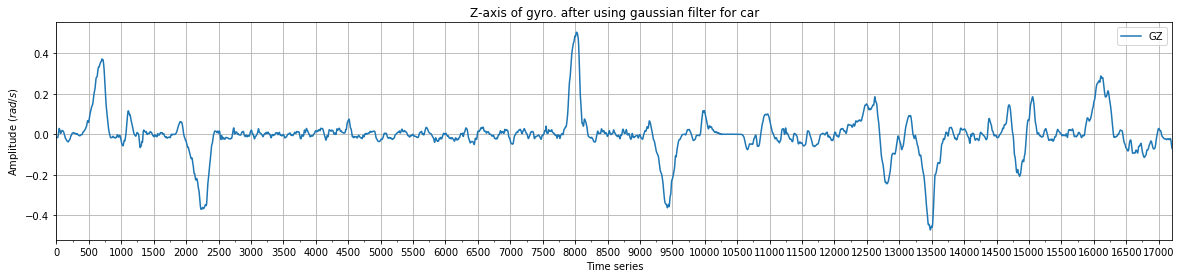

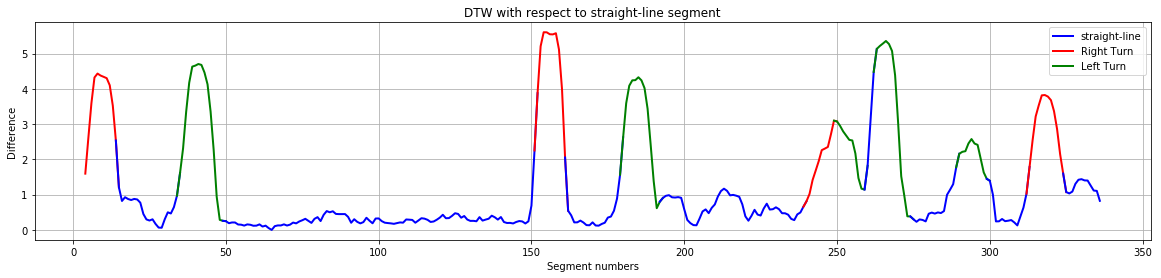

In [28]:
loss_series = pd.Series(diff_wrt_ST)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
car_colors = pltcolor(car_labels)
fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series
x = np.arange(len(y))
plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()